In [ ]:
from google.colab import files
upload = files.upload()

Saving edges.csv to edges.csv
Saving nodes.csv to nodes.csv


In [ ]:
!pip install geopandas
!pip install networkx
!pip install EoN

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "/usr/local/lib/python3.7/dist-packages/pip/_intern

In [ ]:
import networkx as nx
import csv
import EoN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas
import folium

In [ ]:
G = nx.Graph()

In [ ]:
edges_dataset_path = 'edges.csv'
nodes_dataset_path = 'nodes.csv'

In [ ]:
airline_network_edges = open(edges_dataset_path, 'rb')
G = nx.read_edgelist(airline_network_edges, delimiter=',')

In [ ]:
print(len(G.nodes))
print(len(G.edges))

3425
19257


In [ ]:
tau = 1
gamma = 0
initially_infected = 'WUH'

# Initialise number of time steps it took to get infected (T_i) as -1
nx.set_node_attributes(G, 100, 'T_i')

# Sum T_i observed for 100 SIR simulations
for i in range(100):
    simulation_object = EoN.fast_SIR(G, tau, gamma, initially_infected, return_full_data = True)
    for node in G.nodes:
        if(len(simulation_object.node_history(node)[0]) > 1):
            if G.nodes[node]['T_i'] == 100:
                G.nodes[node]['T_i'] = 0
            G.nodes[node]['T_i'] += simulation_object.node_history(node)[0][1]

# Change T_i value for each node so now it holds the average T_i
for node in G.nodes:
    G.nodes[node]['T_i'] /= 100
    G.nodes[node]['Degree'] = G.degree(node)
    
G.nodes['WUH']['T_i'] = 0

In [ ]:
all_node_degrees = []
all_node_average_T_i = []

for node in G.nodes:
    all_node_degrees.append(G.nodes[node]['Degree'])
    all_node_average_T_i.append(G.nodes[node]['T_i'])

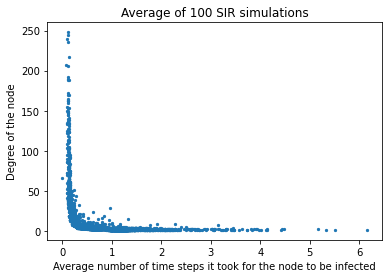

In [ ]:
plt.scatter(all_node_average_T_i, all_node_degrees, 5)
plt.title('Average of 100 SIR simulations')
plt.xlabel('Average number of time steps it took for the node to be infected')
plt.ylabel('Degree of the node')
plt.show()

In [ ]:
d_WUH = []
for node in G.nodes:
    try:
        d_WUH.append(nx.shortest_path_length(G, source='WUH', target=node))
    except nx.NetworkXNoPath as e:
        d_WUH.append(None)

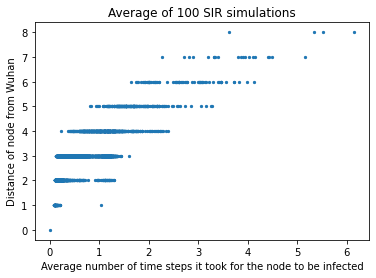

In [ ]:
plt.scatter(all_node_average_T_i, d_WUH, 5)
plt.title('Average of 100 SIR simulations')
plt.xlabel('Average number of time steps it took for the node to be infected')
plt.ylabel('Distance of node from Wuhan')
plt.show()

In [ ]:
nodes_csv = csv.reader(open(nodes_dataset_path, encoding = 'utf-8'))
for row in nodes_csv:
    if row[0] in G:
        G.add_node(row[0], country = row[2],  pos = (float(row[4]), float(row[3])))

nodes_without_pos = []
for node in G.nodes:       
    if 'pos' not in G.nodes[node]:
        nodes_without_pos.append(node)
        
for node in nodes_without_pos:
    G.remove_node(node)

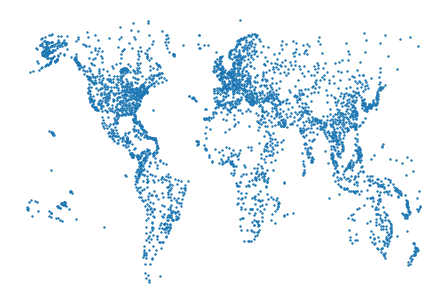

In [ ]:
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels = False, edgelist = [], node_size = 2)

In [ ]:
Countries = []
Country_T_i = []
Country_pos_latitude = []
Country_pos_longitude = []
for node in G.nodes:
    if G.nodes[node]['country'] not in Countries:
        Countries.append(G.nodes[node]['country'])
        Country_T_i.append([G.nodes[node]['T_i']])
        Country_pos_latitude.append([G.nodes[node]['pos'][0]])
        Country_pos_longitude.append([G.nodes[node]['pos'][1]])
    else :
        index = Countries.index(G.nodes[node]['country'])
        Country_T_i[index].append(G.nodes[node]['T_i'])
        Country_pos_latitude[index].append(G.nodes[node]['pos'][0])
        Country_pos_longitude[index].append(G.nodes[node]['pos'][1])

In [ ]:
for i in range(len(Country_T_i)):
    Country_T_i[i] = sum(Country_T_i[i])/len(Country_T_i[i])
    Country_pos_latitude[i] = sum(Country_pos_latitude[i])/len(Country_pos_latitude[i])
    Country_pos_longitude[i] = sum(Country_pos_longitude[i])/len(Country_pos_longitude[i])

In [ ]:
print(Countries[23])
Countries[23] = 'United States of America'
print(Countries[23])

United States
United States of America


In [ ]:
W = nx.Graph()
for i in range(len(Countries)):
    W.add_node(Countries[i], T_i = Country_T_i[i], Pos = (Country_pos_latitude[i], Country_pos_longitude[i]))

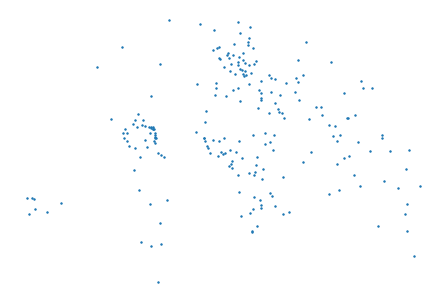

In [ ]:
nx.draw(W, nx.get_node_attributes(W, 'Pos'), with_labels = False, edgelist = [], node_size = 2)

In [ ]:
dataset = {
    'Country': [],
    'T_i': []
}
for i in range(len(Countries)):
    dataset['Country'].append(Countries[i])
    dataset['T_i'].append(Country_T_i[i])

In [ ]:
table = pd.DataFrame(dataset)
print(table)

                     Country       T_i
0                     Russia  0.619842
1                 Azerbaijan  0.608422
2                       Peru  0.911591
3              Cote d'Ivoire  0.188432
4               Burkina Faso  0.440038
..                       ...       ...
221        Wallis and Futuna  1.286134
222               Micronesia  1.414028
223  Cocos (Keeling) Islands  2.170281
224         Christmas Island  1.202410
225                   Monaco  0.944767

[226 rows x 2 columns]


In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
print(world)

       pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    M

In [ ]:
table = world.merge(table, how="left", left_on=['name'], right_on=['Country'])
print(table)

       pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  \
0    

In [ ]:
table = table.dropna(subset=['T_i'])
print(table)

       pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
5     18556698           Asia                Kazakhstan    KAZ    460700.0   
..         ...            ...                       ...    ...         ...   
169   11901484         Africa                    Rwanda    RWA     21970.0   
171    2103721         Europe                 Macedonia    MKD     29520.0   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   

                                              geometry  \
0    

In [ ]:
world_map = folium.Map()

In [ ]:
world_map = folium.Map()
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['Country', 'T_i'],
    key_on='feature.properties.name',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color = 'White',
    legend_name='Number of time steps taken to get infected'
).add_to(world_map)

In [ ]:
display(world_map)

In [ ]:
world_map.save('covid19.png')